# Assignment 2

This program makes plots of monthly climatology of vertically integrated twice daily ERA5 horizontal wind for 1986-2015 in the Pacific North American region. This acts as a proxy for vertically integrated moisture flux, until the specific humidity data (q) can be accessed.

1. Read in ERA5 u, v:
    * NDJFM data for a given variable: `/glade/work/mkorendy/metisregimes/era5.AR.variable_pna_NDJFM.1986-2016.nc`
    * April through October data for a given variable: `/glade/work/mkorendy/metisregimes/era5.AR.variable_pna_A-O.1986-2016.nc`


2. Get vertically integrated proxy for moisture flux: vertically integrate horizontal wind, weighted by pressure, divided by gravitational acceleration
    * Note: once specific humidity (q) data is available, multiply wind by q to get moisture flux


3. Calculate magnitude of vertically integrated proxy

4. Calculate monthly climatologies

5. Plot monthly climatologies in 12-panel plot

## Imports

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

## Files

In [2]:
#Path
path = '/glade/work/mkorendy/metisregimes/'

#NDJFM Files
f_u = path + 'era5.AR.u_pna_NDJFM.1986-2016.nc'
f_v = path + 'era5.AR.v_pna_NDJFM.1986-2016.nc'

# AMJJASO Files
f_u2 = path + 'era5.AR.u_pna_A-O.1986-2016.nc'
f_v2 = path + 'era5.AR.v_pna_A-O.1986-2016.nc'

## Read data in

In [3]:
# NDJFM
ds_u = xr.open_dataset(f_u).drop(['number','step','valid_time'])
ds_v = xr.open_dataset(f_v).drop(['number','step','valid_time'])

# April thru October
ds_u2 = xr.open_dataset(f_u2).drop(['number','step','valid_time'])
ds_v2 = xr.open_dataset(f_v2).drop(['number','step','valid_time'])

#Create full year dataset
ds_u = xr.concat([ds_u, ds_u2], dim='time')
ds_v = xr.concat([ds_v, ds_v2], dim='time')

## Integrate over pressure

In [4]:
#Integration based on metis level thicknesses, and so requires specified level thicknesses
#Define level pressure thickness
thickness = [1000-962.5, 962.5 - 887.5, 887.5 - 775, 100, 100, 100, 100, 100, 100, 100, 150-75, 75-40, 40-20, 400-350]
len(thickness)

14

In [5]:
levs = ds_u['isobaricInhPa']
uqvi = []
vqvi = []

#Multiply the winds by their pressure level's thickness
#Divide by gravity to get proxy for moisture flux
for k in np.arange(0,len(thickness)-1):
    uqvi.append(ds_u.sel(isobaricInhPa = levs[k]) * (thickness[k])/9.81)
    vqvi.append(ds_v.sel(isobaricInhPa = levs[k]) * (thickness[k])/9.81)

In [6]:
ds_uqvi = xr.combine_nested(uqvi, concat_dim='levs')
ds_vqvi = xr.combine_nested(vqvi, concat_dim='levs')

In [7]:
# Sum over pressure levels to get column total, pressure-weighted proxy for moisture flux
da_uqvi = ds_uqvi.sum('levs')
da_vqvi = ds_vqvi.sum('levs')

## Calculate magnitude of horizontal wind

In [8]:
ds_mag = (da_uqvi['u']**2 + da_vqvi['v']**2)**(1/2)
ds_mag

<xarray.DataArray (time: 21914, lat: 22, lon: 53)>
array([[[1287.3649  , 1242.2368  , 1211.7284  , ...,  480.7114  ,
          511.19632 ,  614.76984 ],
        [1614.8184  , 1537.9004  , 1417.9424  , ...,  755.6697  ,
          776.67346 ,  639.41187 ],
        [1745.0348  , 1768.7897  , 1588.3774  , ...,  677.6322  ,
          664.813   ,  720.54047 ],
        ...,
        [ 564.43726 ,  597.235   ,  673.68933 , ...,  254.57942 ,
           56.845806,  461.5996  ],
        [  68.22363 ,  237.8584  ,  413.3227  , ...,  514.9076  ,
          625.3502  , 1019.63007 ],
        [ 206.9894  ,  214.17123 ,  125.6905  , ...,  968.001   ,
         1029.4575  , 1331.2336  ]],

       [[1089.023   ,  943.8556  ,  762.4721  , ...,  806.3184  ,
          861.1966  ,  929.697   ],
        [1533.4264  , 1362.2621  , 1143.4604  , ...,  670.99945 ,
          799.64386 ,  799.9698  ],
        [1431.8092  , 1457.6741  , 1303.8694  , ...,  642.73    ,
          670.54016 ,  720.2757  ],
        ...,
        [ 596.6572  ,  648.75    ,  740.4729  , ...,  236.34227 ,
          434.43906 ,  722.69196 ],
        [  32.259914,  244.59837 ,  374.7762  , ...,  466.60645 ,
          616.9221  ,  829.21045 ],
        [ 503.45953 ,  447.88312 ,  540.68494 , ...,  831.83484 ,
          973.67834 , 1189.4387  ]],

       [[ 848.62616 ,  616.01276 ,  403.15244 , ...,  955.30414 ,
          852.44165 ,  805.08154 ],
        [1204.7617  , 1023.1376  ,  815.18695 , ...,  591.57794 ,
          663.9886  ,  601.96106 ],
        [ 879.5568  , 1007.55914 , 1070.6658  , ...,  531.86755 ,
          652.6606  ,  749.20734 ],
        ...,
        [ 674.3688  ,  518.4621  ,  596.49475 , ...,  380.09598 ,
          557.1267  ,  778.00055 ],
        [  98.17656 ,  201.11436 ,  426.7568  , ...,  278.96985 ,
          533.3394  ,  845.3293  ],
        [ 531.23206 ,  644.4781  ,  684.5487  , ...,  690.25226 ,
          807.9828  , 1038.7881  ]],

       ...,

       [[ 535.6933  ,  570.82825 ,  617.69385 , ..., 1865.4403  ,
         2090.866   , 2258.7805  ],
        [ 677.6237  ,  685.8726  ,  745.2451  , ..., 1971.2635  ,
         2362.4211  , 2614.5996  ],
        [ 993.26495 , 1024.7217  , 1134.1215  , ...,  979.9017  ,
         1192.1815  , 1532.1262  ],
        ...,
        [ 191.80031 ,  124.77814 ,  112.587975, ...,  562.5162  ,
          416.5728  ,  348.26645 ],
        [ 195.87909 ,   94.00468 ,  267.23514 , ...,  366.02655 ,
          239.5765  ,  193.0601  ],
        [ 308.69623 ,  449.3983  ,  636.8876  , ...,  238.09846 ,
          170.84492 ,  261.04703 ]],

       [[ 500.9203  ,  486.3046  ,  448.64606 , ..., 1318.5316  ,
         1456.56    , 1672.0398  ],
        [ 823.3106  ,  714.8595  ,  675.9522  , ..., 1067.0487  ,
         1152.822   , 1122.6857  ],
        [ 751.0675  ,  754.41797 ,  766.434   , ..., 1196.0522  ,
         1331.3212  , 1264.1285  ],
        ...,
        [ 179.70377 ,  262.06412 ,  410.7549  , ...,  866.5507  ,
          620.7167  ,  462.59064 ],
        [ 174.07503 ,   76.71987 ,  369.8897  , ...,  415.22687 ,
          376.74713 ,  267.4361  ],
        [ 372.49496 ,  435.1803  ,  639.6908  , ...,  259.73343 ,
          284.53644 ,  263.74298 ]],

       [[ 888.10046 ,  735.15564 ,  575.07874 , ...,  765.5877  ,
          868.40607 , 1072.6407  ],
        [1007.3089  ,  809.88855 ,  676.6371  , ...,  687.8692  ,
          913.31647 , 1168.1964  ],
        [ 874.5916  ,  733.1804  ,  616.59576 , ...,  966.2124  ,
         1213.0143  , 1494.8948  ],
        ...,
        [ 361.86987 ,  308.38068 ,  565.3699  , ...,  827.6512  ,
          642.57605 ,  456.80234 ],
        [ 221.93259 ,  117.33191 ,  314.82355 , ...,  531.1033  ,
          383.71603 ,  256.0627  ],
        [ 375.7533  ,  419.4711  ,  566.1892  , ...,  349.12    ,
          188.94057 ,  217.62218 ]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
  * time     (time) datetime64[ns] 1986-11-01 ... 2015-10-31T12:00:

## Calculate monthly climatologies

In [9]:
# Take monthly means
ds_clim = ds_mag.groupby('time.month').mean()
ds_clim

<xarray.DataArray (month: 12, lat: 22, lon: 53)>
array([[[1328.2875 , 1337.3083 , 1344.1279 , ...,  919.6923 ,
          930.5656 ,  990.9421 ],
        [1366.4166 , 1372.4877 , 1376.06   , ...,  945.78937,
          990.4969 , 1005.55194],
        [1352.711  , 1359.4347 , 1363.9454 , ..., 1014.10114,
         1041.2397 , 1073.585  ],
        ...,
        [3019.9265 , 2974.8274 , 2926.537  , ..., 1701.6328 ,
         1639.1941 , 1567.6143 ],
        [2113.9546 , 2072.3967 , 2035.328  , ..., 1274.6545 ,
         1241.9512 , 1208.4403 ],
        [1226.4011 , 1205.2979 , 1187.1494 , ...,  939.2107 ,
          940.62384,  944.4131 ]],

       [[1269.8663 , 1282.6904 , 1296.2635 , ...,  951.28534,
          950.0634 ,  994.1993 ],
        [1266.4789 , 1278.6138 , 1290.5544 , ...,  940.6444 ,
          971.93634,  984.49054],
        [1246.058  , 1255.2693 , 1260.3562 , ...,  984.0999 ,
          996.03986, 1018.44556],
        ...,
        [3065.0938 , 3029.157  , 2985.724  , ..., 1867.7672 ,
         1812.2842 , 1748.6919 ],
        [2240.8394 , 2211.5059 , 2179.1667 , ..., 1434.404  ,
         1407.5768 , 1379.7096 ],
        [1398.0588 , 1386.07   , 1374.5176 , ..., 1095.51   ,
         1099.5123 , 1105.9609 ]],

       [[1300.8175 , 1314.7805 , 1328.5869 , ...,  943.618  ,
          933.3109 ,  957.7052 ],
        [1290.9904 , 1307.0774 , 1322.5607 , ...,  947.83453,
          961.2591 ,  961.78864],
        [1262.3339 , 1283.7943 , 1306.331  , ..., 1049.2528 ,
         1048.4639 , 1048.4585 ],
        ...,
        [2535.1577 , 2450.909  , 2360.2705 , ..., 1804.2202 ,
         1774.3842 , 1735.6212 ],
        [1877.288  , 1816.4481 , 1756.5687 , ..., 1515.436  ,
         1495.7383 , 1478.6311 ],
        [1202.1012 , 1187.1459 , 1172.7631 , ..., 1221.5485 ,
         1223.415  , 1227.8181 ]],

       ...,

       [[1018.4158 , 1023.28687, 1029.9204 , ...,  884.4653 ,
          897.08   ,  930.34814],
        [1036.6772 , 1043.3787 , 1047.2941 , ...,  907.04443,
          904.60144,  903.95764],
        [1059.3862 , 1062.0894 , 1062.5051 , ..., 1072.6708 ,
         1064.4626 , 1060.155  ],
        ...,
        [ 690.3366 ,  686.14905,  692.1874 , ...,  788.3964 ,
          774.8782 ,  773.0099 ],
        [ 659.21924,  668.557  ,  696.5632 , ...,  662.4905 ,
          673.32635,  680.0777 ],
        [ 734.2868 ,  741.89465,  759.75903, ...,  611.2451 ,
          613.64984,  612.9643 ]],

       [[1167.7291 , 1176.6575 , 1186.6006 , ...,  934.31384,
          957.31036, 1011.54144],
        [1175.999  , 1185.5809 , 1193.783  , ...,  962.2399 ,
          982.50165,  989.8646 ],
        [1152.456  , 1161.2913 , 1167.6045 , ..., 1056.3364 ,
         1063.0266 , 1083.2546 ],
        ...,
        [1312.457  , 1253.2018 , 1207.6445 , ..., 1167.6025 ,
         1140.4828 , 1113.651  ],
        [ 802.7439 ,  799.8538 ,  805.14124, ...,  949.6453 ,
          947.65625,  946.3791 ],
        [ 630.9953 ,  659.9141 ,  693.7358 , ...,  789.44525,
          808.119  ,  822.05145]],

       [[1259.0116 , 1267.4445 , 1274.6875 , ...,  914.06934,
          928.8709 ,  985.9491 ],
        [1219.9152 , 1221.2554 , 1222.3752 , ...,  946.1565 ,
          979.14105,  993.0916 ],
        [1182.0566 , 1180.875  , 1182.9777 , ..., 1057.4264 ,
         1077.6367 , 1103.8612 ],
        ...,
        [2314.8667 , 2250.9524 , 2191.9    , ..., 1508.1432 ,
         1477.8091 , 1442.9418 ],
        [1448.548  , 1406.1791 , 1373.727  , ..., 1167.4403 ,
         1158.479  , 1150.1854 ],
        [ 780.52203,  775.85626,  781.62506, ...,  898.4888 ,
          913.11774,  932.1507 ]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

## Plot monthly climatologies

In [10]:
#Subplot titles
titles = ['January', 'February', 'March', 'April', 
          'May', 'June', 'July', 'August', 'September',
         'October', 'November', 'December']

In [11]:
# Set colors
clevs = np.arange(np.round(min(ds_clim.values.flatten())),np.round(max(ds_clim.values.flatten())), 10)

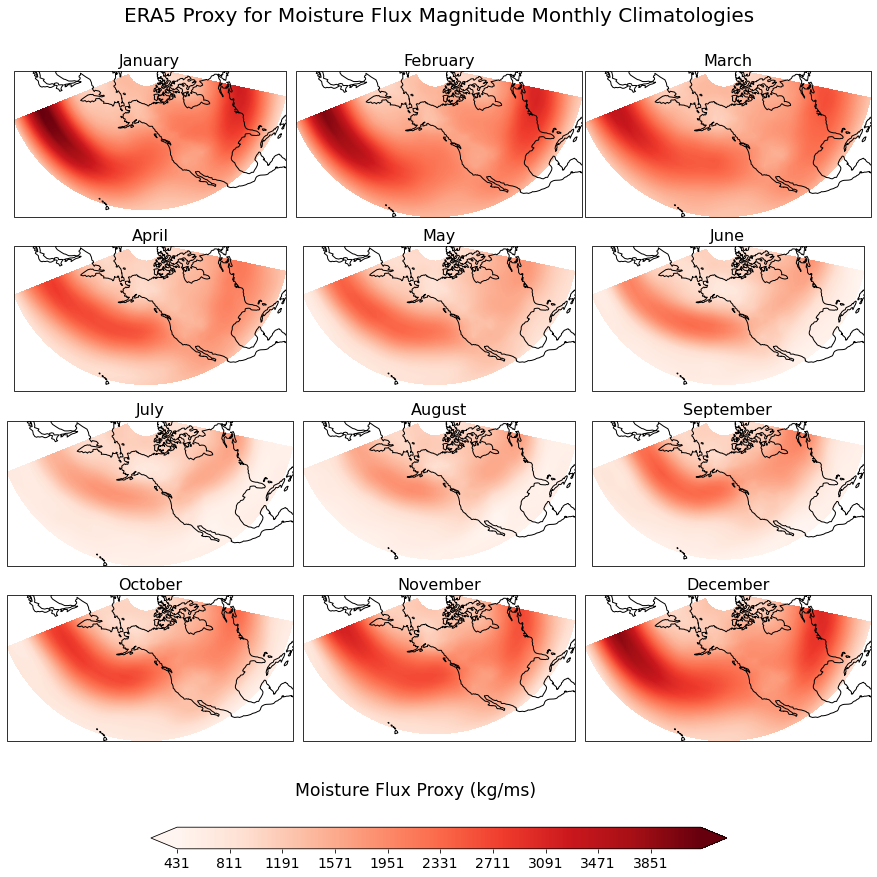

In [22]:
cm = 220

data_crs = ccrs.PlateCarree(central_longitude=cm)
proj = ccrs.NorthPolarStereo(central_longitude=cm)

# Set the axes using the specified map projection
fig,axs=plt.subplots(4,3,subplot_kw={'projection':proj},figsize=(20,15))

for i,ax in enumerate(axs.flatten()):
    cs=ax.contourf(ds_clim['lon'],ds_clim['lat'],
                    ds_clim[i,:,:],clevs,
                    transform=ccrs.PlateCarree(),
                    cmap='Reds',extend='both')
    ax.set_title(titles[i],fontdict={'fontsize':16})
    ax.coastlines()

plt.suptitle('ERA5 Proxy for Moisture Flux Magnitude Monthly Climatologies',fontsize=20)
plt.figtext(.4,.25,'Moisture Flux Proxy (kg/ms)',fontsize='xx-large')

# Add Colorbar
fig.subplots_adjust(bottom=0.3, top=0.92, left=0.2, right=0.8,
                    wspace=0.01, hspace=0.2)
cbar_ax = fig.add_axes([0.3, 0.2, 0.4, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=14) 